# Does more Sky Background subtraction CTIO Data in May-June 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : May 31th 2017


- Analysis of star HD111980Night 29 May 2017 at CTIO.
- Main purpose : Spectrum in different gratings/holograms 




- 20:40 Filtre bleu f5025/1023. Focus: départ 12500. Valeur mesurée 12750, seeing 1.4", T=6.9°C. Variation de foyer entre rien et le filtre bleu = +200

Nouvelle séquence d’analyse des 5 réseaux avec filtre bleu :
python make_filter_scripts.py -1 f5025/1023 -2 Ron400,Thor300,HoloPhP,HoloPhAg,HoloAmAg -c 1 -O HD11980 -r "12 54 06.9" -d "-18 39 30" -e 300 -n 2

scp script_filters.objs  observer@new-ctioa4.ctio.noao.edu:/home/observer/scripts/

- 21:50 Séquence 5 réseaux avec filtre bleu f5025/1023 avec 2 poses de 300s pour chaque réseau (600s pour holoAmpAg). #60 à #69.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
from matplotlib.colors import LogNorm

In [2]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [6]:
outputdir="processed_fitsimages"
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

### User must fill its info below

In [1]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=60
MAX_IMGNUMBER=69
object_name='HD111980_f5025_1023 29th may 17'
SelectTagRe='^trim_20170529_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170529_[0-9]+.fits$'
NBIMGPERROW=4

In [8]:
#dirlist_all=os.listdir(rootpath_rawimage) 

In [9]:
#if '.DS_Store' in dirlist_all:
#    dirlist_all.remove('.DS_Store')
dirlist=[]
dirlist.append(inputdir)
dirlist_all=np.array(dirlist)

In [10]:
print dirlist_all

['../OverScanRemove/trim_images']


In [11]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [12]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return

In [13]:
MakeFileList()   # Make the list

In [14]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [15]:
print len(indexes_files)

9


In [16]:
print len(filelist_fitsimages)

9


In [17]:
print indexes_files

[49 50 51 52 53 54 55 56 57]


In [18]:
len(indexes_files)

9

In [19]:
filelist_fitsimages

array(['../OverScanRemove/trim_images/trim_20170529_049.fits',
       '../OverScanRemove/trim_images/trim_20170529_050.fits',
       '../OverScanRemove/trim_images/trim_20170529_051.fits',
       '../OverScanRemove/trim_images/trim_20170529_052.fits',
       '../OverScanRemove/trim_images/trim_20170529_053.fits',
       '../OverScanRemove/trim_images/trim_20170529_054.fits',
       '../OverScanRemove/trim_images/trim_20170529_055.fits',
       '../OverScanRemove/trim_images/trim_20170529_056.fits',
       '../OverScanRemove/trim_images/trim_20170529_057.fits'], 
      dtype='|S52')

In [20]:
len(filelist_fitsimages)

9

In [21]:
#sorted_dates=np.argsort(filelist_fitsimages)

In [22]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [23]:
sorted_indexes

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
#print sorted_dates

In [25]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8]


In [26]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [27]:
#sorted_numbers= [indexes_files[index] for index in sorted_indexes]
sorted_numbers=indexes_files[sorted_indexes]

In [28]:
sorted_numbers

array([49, 50, 51, 52, 53, 54, 55, 56, 57])

In [29]:
sorted_files

array(['../OverScanRemove/trim_images/trim_20170529_049.fits',
       '../OverScanRemove/trim_images/trim_20170529_050.fits',
       '../OverScanRemove/trim_images/trim_20170529_051.fits',
       '../OverScanRemove/trim_images/trim_20170529_052.fits',
       '../OverScanRemove/trim_images/trim_20170529_053.fits',
       '../OverScanRemove/trim_images/trim_20170529_054.fits',
       '../OverScanRemove/trim_images/trim_20170529_055.fits',
       '../OverScanRemove/trim_images/trim_20170529_056.fits',
       '../OverScanRemove/trim_images/trim_20170529_057.fits'], 
      dtype='|S52')

## Build full filename
----------------------------

In [30]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(rootpath_rawimage,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [31]:
sorted_filenames=np.array(sorted_filenames)

In [32]:
sorted_filenames

array(['../OverScanRemove/trim_images/trim_20170529_049.fits',
       '../OverScanRemove/trim_images/trim_20170529_050.fits',
       '../OverScanRemove/trim_images/trim_20170529_051.fits',
       '../OverScanRemove/trim_images/trim_20170529_052.fits',
       '../OverScanRemove/trim_images/trim_20170529_053.fits',
       '../OverScanRemove/trim_images/trim_20170529_054.fits',
       '../OverScanRemove/trim_images/trim_20170529_055.fits',
       '../OverScanRemove/trim_images/trim_20170529_056.fits',
       '../OverScanRemove/trim_images/trim_20170529_057.fits'], 
      dtype='|S52')

## Acces to data of  images
----------------------------------

In [33]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt= []

In [34]:
def BuildRawImages():
    """
    BuildRawImages
    ===============
    """

    global all_dates
    global all_airmass
    global all_images
    global all_titles
    global all_header
    global all_img 
    global sorted_filenames
    global all_filt

    for idx,file in np.ndenumerate(sorted_filenames):   
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
        num=sorted_numbers[idx[0]]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()

In [35]:
BuildRawImages()

In [36]:
all_header[0]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBJECT  = 'HD11980 '           / Name of object observed                        
OBSERVER= '        '           / observer                                       
PROPID  = '        '           / Proposal ID                                    
RECID   = 'ct36.20170530.000913' / NOAO Archibe record ID                       
PROPID  = '        '           / Proposal ID                                    
IMAGETYP= 'object  '        

## Show images
-----------------------

In [37]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,15))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=1000)
        #axarr[iy,ix].annotate(all_filt[index], xy=(1000., 1500.),fontsize=16,color='yellow')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)        

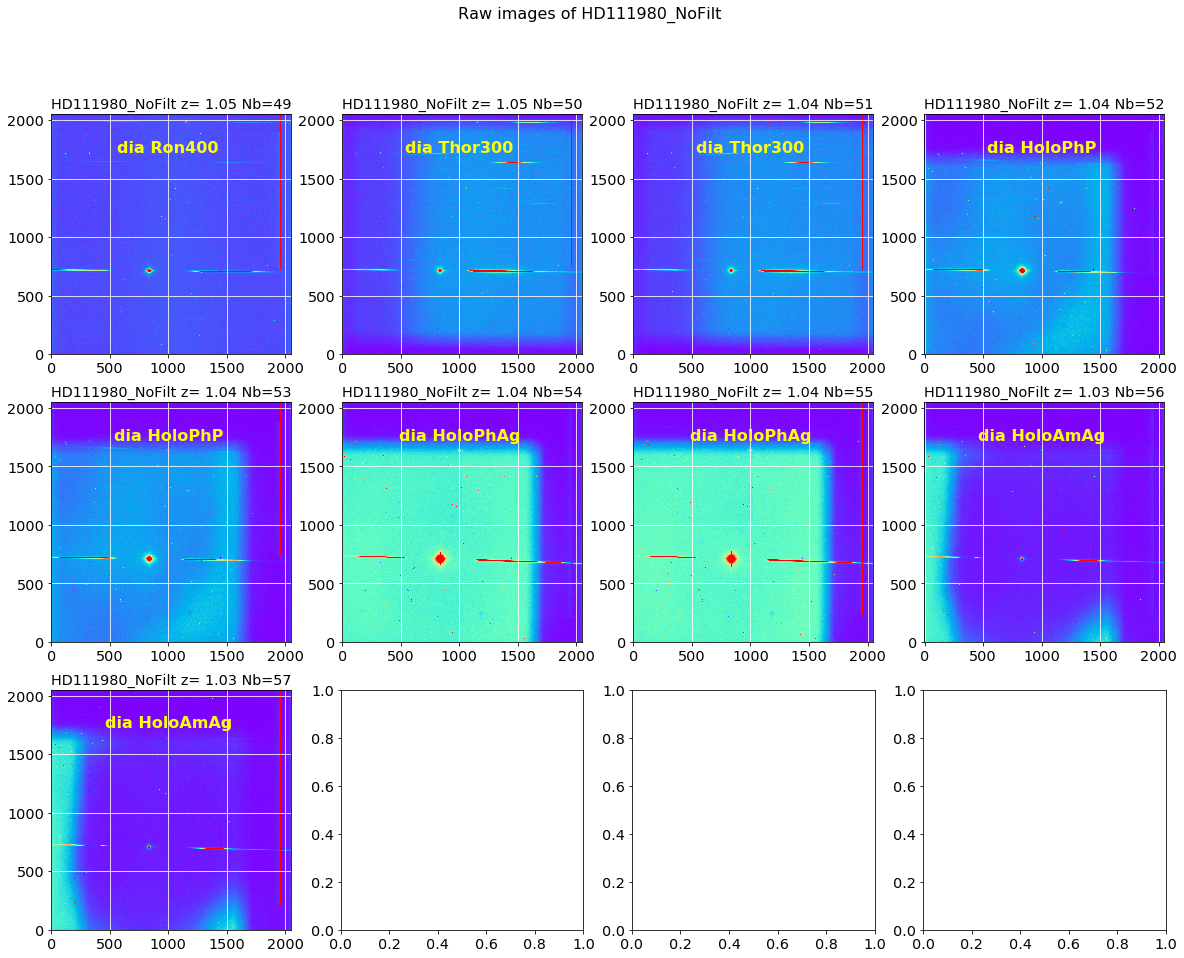

In [38]:
ShowRawImages()

## Show histograms
===========================

In [39]:
def ShowHistograms():
    """
    ShowHistograms
    ==============
    """
    global all_images
    global all_titles
    global object_name


    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,15))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        image_flat=all_images[index].flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=100,range=(-50,10000),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e10)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histograms of images {}  '.format(object_name)
    plt.suptitle(title,size=16)        

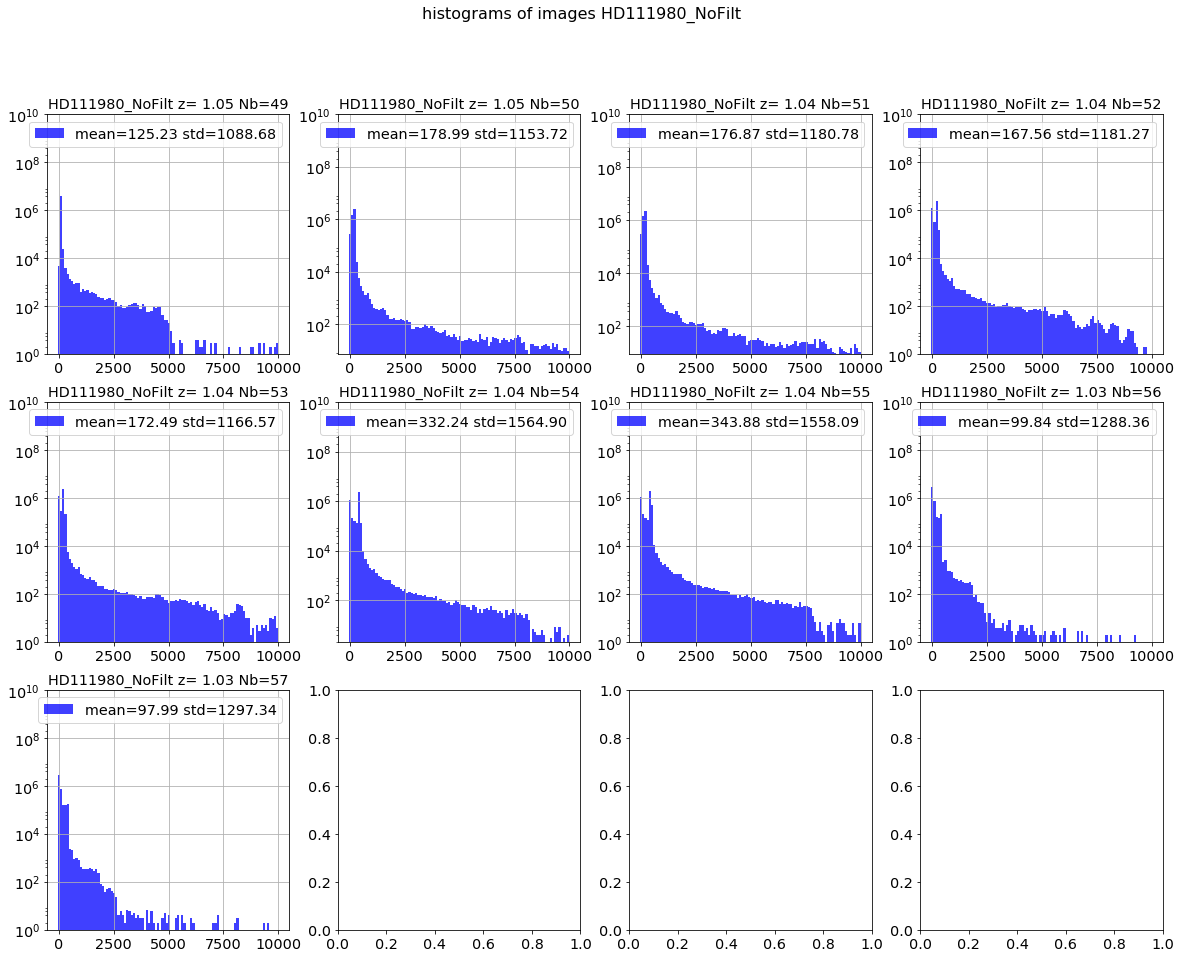

In [40]:
ShowHistograms()